In [ ]:
%load_ext autoreload
%autoreload 2

# Text: Core

> The `text.core` module contains the core bits required to use fast.ai's low-level and/or mid-level APIs to define `Datasets`, build `DataLoaders`, and train text/NLP models with fast.ai

In [ ]:
# |default_exp text.core
# |default_cls_lvl 3

In [ ]:
# |export
from __future__ import annotations

import gc, importlib, sys, traceback

from accelerate.logging import get_logger
from dataclasses import dataclass
from datasets import concatenate_datasets, load_dataset
from dotenv import load_dotenv
from fastai.callback.all import *
from fastai.imports import *
from fastai.learner import *
from fastai.losses import BaseLoss, BCEWithLogitsLossFlat, CrossEntropyLossFlat
from fastai.data.transforms import DataLoaders, Datasets, ColSplitter, ItemTransform, TfmdDL
from fastai.optimizer import Adam, OptimWrapper, params
from fastai.metrics import accuracy, F1Score, accuracy_multi, F1ScoreMulti
from fastai.test_utils import show_install
from fastai.torch_core import *
from fastai.torch_imports import *
from transformers import AutoConfig, AutoTokenizer, PretrainedConfig, PreTrainedTokenizerBase, PreTrainedModel
from transformers import AutoModelForSequenceClassification
from transformers import logging as hf_logging
from transformers.data.data_collator import DataCollatorWithPadding

from blurr.utils import clean_memory, get_hf_objects, set_seed, PreCalculatedLoss

In [ ]:
# |hide
import pdb

from datasets import Value
from fastai.data.block import CategoryBlock, ColReader, ColSplitter, DataBlock, ItemGetter, RandomSplitter, FuncSplitter
from fastai.text.data import SortedDL
from fastcore.test import *
import nbdev

from blurr.utils import print_versions, PreCalculatedCrossEntropyLoss, PreCalculatedBCELoss, PreCalculatedMSELoss

In [ ]:
# |export
# silence all the HF warnings and load environment variables
warnings.simplefilter("ignore")
hf_logging.set_verbosity_error()
logger = get_logger(__name__)

load_dotenv()

False

In [ ]:
# |hide
# |notest
torch.cuda.set_device(0)
print(f"Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}")

Using GPU #0: NVIDIA GeForce RTX 3090


In [ ]:
# | echo: false
os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("What we're running with at the time this documentation was generated:")
print_versions("torch fastai transformers")

What we're running with at the time this documentation was generated:
torch: 1.13.1
fastai: 2.7.11
transformers: 4.26.1


## Setup

We'll use a subset of `imdb` to demonstrate how to configure your BLURR for sequence classification tasks. **BLURR** is designed to work with Hugging Face `Dataset` and/or pandas `DataFrame` objects

In [ ]:
def get_new_hf_objects(labels):
    model_cls = AutoModelForSequenceClassification
    hf_logging.set_verbosity_error()

    pretrained_model_name = "microsoft/deberta-v3-small"
    n_labels = len(labels)

    hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(
        pretrained_model_name, model_cls=model_cls, config_kwargs={"num_labels": n_labels}
    )

    hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

    print("=== config ===")
    print(f"# of labels:\t{hf_config.num_labels}")
    print("")
    print("=== tokenizer ===")
    print(f"Vocab size:\t\t{hf_tokenizer.vocab_size}")
    print(f"Max # of tokens:\t{hf_tokenizer.model_max_length}")
    print(f"Attributes expected by model in forward pass:\t{hf_tokenizer.model_input_names}")

    return hf_arch, hf_config, hf_tokenizer, hf_model

### Multiclass

In [ ]:
imdb_dsd = load_dataset("imdb", split=["train", "test"])

# build HF `Dataset` objects
train_ds = imdb_dsd[0].add_column("is_valid", [False] * len(imdb_dsd[0])).shuffle().select(range(1000))
valid_ds = imdb_dsd[1].add_column("is_valid", [True] * len(imdb_dsd[1])).shuffle().select(range(200))
imdb_ds = concatenate_datasets([train_ds, valid_ds])

# build a `DataFrame` representation as well
imdb_df = pd.DataFrame(imdb_ds)

print(len(train_ds), len(valid_ds))
print(len(imdb_df[imdb_df["is_valid"] == False]), len(imdb_df[imdb_df["is_valid"] == True]))
imdb_df.head()

Found cached dataset imdb (/home/wgilliam/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/2 [00:00<?, ?it/s]

1000 200
1000 200


,text,label,is_valid
0,"This movie is just plain terrible!!!! Slow acting, slow at getting to the point and wooden characters that just shouldn't have been on there. The best part was the showing of Iron Maiden singing in some video at a theater and thats it. the ending was worth watching and waiting up for but that was it!! The characters in this movie put me to sleep almost. Avoid it!!!",0,False
1,"It would require the beauty and eloquence of Shakespeare to do justice to this outstanding cinematic feat. Nevertheless, I'll give it a go.<br /><br />As far as adaptations of Hamlet go this one is already at a better starting point than all other versions since it encompasses the entire play. Still this is no guarantee for a first-rate movie, or even a good one. Usually I'm not much for movies that are overlong and the trend that seems to be prevalent in Hollywood today, namely that movies should be at least two hours long, preferably three, is one that hopefully won't last long. Few stor...",1,False
2,"I really didn't expect much from this movie, but it wasn't bad; actually it was quite good. This movie contained a couple of the funniest bits of writing I have ever seen from a motion picture. Now am not saying this is one of the funniest movies of all time, but I laughed pretty hard at some parts. ""The police ruled my father's death a suicide. They said he fell down an elevator shaft. Onto some bullets"". Now this movie is not for everybody, its mostly stupid humor like Zoolander or Dodgeball; so if you hated these movies I would probably recommend you to steer clear. Overall it was an en...",1,False
3,"This movie was different in that it didn't show the typical gay stereotypes that I'm used to seeing. But that doesn't change the fact that it totally lacks a storyline. I'm sure that there are many gay men who are just happy to see themselves depicted on screen, since Black gay characters are seldom seen, and when they are the characters are usually not fully developed. But, how hard would it have been for the writer to actually script a story with a beginning, middle and end. Or how about a story that was focused. There really doesn't seem to be a point to this film, and even though it is...",0,False
4,"I was browsing through Netflix and stumbled upon this movie. Having fond memories of the book as a child, I decided to check this out. This is a movie that you should really pass on.<br /><br />It is just not worth seeing. It is very boring and uninteresting. I feel that it would even be that way to small children. It has no magic that the book contains. This movie is not horrible, but you will just find yourself not caring ten minutes into it.<br /><br />There are moments that just come off as weird. The witch character is not very good. The family acts like it is no big deal that these o...",0,False


In [ ]:
labels = imdb_dsd[0].features["label"].names
labels

['neg', 'pos']

### Multilabel

In [ ]:
civil_dsd = load_dataset("civil_comments", split=["train", "validation"])

# round the floats
civil_labels = ["toxicity", "severe_toxicity", "obscene", "threat", "insult", "identity_attack", "sexual_explicit"]


def round_targs(example):
    for lbl in civil_labels:
        example[lbl] = np.round(example[lbl])
    return example


# convert floats to ints
def fix_dtypes(ds):
    new_features = ds.features.copy()
    for lbl in civil_labels:
        new_features[lbl] = Value("int32")
    return ds.cast(new_features)


# build HF `Dataset` objects
civil_train_ds = civil_dsd[0].add_column("is_valid", [False] * len(civil_dsd[0])).shuffle().select(range(1000))
civil_train_ds = civil_train_ds.map(round_targs)
civil_train_ds = fix_dtypes(civil_train_ds)

civil_valid_ds = civil_dsd[1].add_column("is_valid", [True] * len(civil_dsd[1])).shuffle().select(range(200))
civil_valid_ds = civil_valid_ds.map(round_targs)
civil_valid_ds = fix_dtypes(civil_valid_ds)

civil_ds = concatenate_datasets([civil_train_ds, civil_valid_ds])

# build a `DataFrame` representation as well
civil_df = pd.DataFrame(civil_ds)

print(len(civil_train_ds), len(civil_valid_ds))
print(len(civil_df[civil_df["is_valid"] == False]), len(civil_df[civil_df["is_valid"] == True]))
civil_df.head()

Found cached dataset civil_comments (/home/wgilliam/.cache/huggingface/datasets/civil_comments/default/0.9.0/e7a3aacd2ab7d135fa958e7209d10b1fa03807d44c486e3c34897aa08ea8ffab)


  0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

1000 200
1000 200


,text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit,is_valid
0,"At least the Guptas looked after the employment of citizens. Gordhan, Rupert and other White Monopoly Capitalists do not seem to give a damn about the citizens.",0,0,0,0,0,0,0,False
1,"I don't see a problem at all.\n\nShe is on the way out, which is totally sad as she is the BEST Prime Minister this country will never have!\n\nWho would you rather have on the bow of your boat?",0,0,0,0,0,0,0,False
2,"We already have opt out. Some of us want opt in. The school realizes that they can teach what ever they want because most parents aren't paying attention. But with opt-in, parents must pay attention and get involved.",0,0,0,0,0,0,0,False
3,"So your argument is to deflect to Clinton's alleged crimes. \n\nIf you claim is that the Clinton foundation has routed money to any of the Clinton personally, please provide the documentation. \n\nIt's fairly unusual for a Charitable fund to count on the draw of a personality, as Bill Clinton is, but that doesn't mean they don't do good work. Do you accuse Bill and Melinda Gates for profit taking with their foundation? \n\nLet's make it clear, the people that can spend millions on charitable giving aren't found sitting on street corners. You contact them using a person from th...",0,0,0,0,0,0,0,False
4,"Get real. While we are the national capital of homelessness, they are not perishing in the streets. Far from it. They have two to four free meals per day, often delivered (by people who don't live in the 'hoods the homeless have taken over), free clothes, free laundry service and no enforcement of camping laws in ecologically sensitive areas, which they are devastating. We can't even get the cops to stop the assaults on the bike paths from the bums who have taken them over.\n\nThat said, imagine if the city and county spent that $300M building low-income housing at $40k/unit with rent rest...",0,0,0,0,0,0,0,False


## Core: Data

A base collation function that works with a variety of input formats and pads inputs on-the-fly at batch time

### `TextCollatorWithPadding` -

In [ ]:
# |export
@dataclass
class TextCollatorWithPadding:
    def __init__(
        self,
        # A Hugging Face tokenizer
        hf_tokenizer: PreTrainedTokenizerBase,
        # The abbreviation/name of your Hugging Face transformer architecture (e.b., bert, bart, etc..)
        hf_arch: str = None,
        # A specific configuration instance you want to use
        hf_config: PretrainedConfig = None,
        # A Hugging Face model
        hf_model: PreTrainedModel = None,
        # The number of inputs expected by your model
        n_inp: int = 1,
        # Defaults to use Hugging Face's DataCollatorWithPadding(tokenizer=hf_tokenizer)
        data_collator_cls: type = DataCollatorWithPadding,
        # kwyargs specific for the instantiation of the `data_collator`
        data_collator_kwargs: dict = {},
    ):
        store_attr()
        self.hf_tokenizer = data_collator_kwargs.pop("tokenizer", self.hf_tokenizer)
        self.data_collator = data_collator_cls(tokenizer=self.hf_tokenizer, **data_collator_kwargs)

    def __call__(self, features):
        features = L(features)
        inputs, labels, targs = [], [], []

        # features contain dictionaries
        if isinstance(features[0], dict):
            feature_keys = list(features[0].keys())
            inputs = [self._build_inputs_d(features, feature_keys)]

            input_labels = self._build_input_labels(features, feature_keys)
            if input_labels is not None:
                labels, targs = [input_labels], [input_labels.clone()]
        # features contains tuples, each of which can contain multiple inputs and/or targets
        elif isinstance(features[0], tuple):
            for f_idx in range(self.n_inp):
                feature_keys = list(features[0][f_idx].keys())
                inputs.append(self._build_inputs_d(features.itemgot(f_idx), feature_keys))

                input_labels = self._build_input_labels(features.itemgot(f_idx), feature_keys)
                labels.append(input_labels if input_labels is not None else [])

            targs = [self._proc_targets(list(features.itemgot(f_idx))) for f_idx in range(self.n_inp, len(features[0]))]

        return self._build_batch(inputs, labels, targs)

    # ----- utility methods -----

    # to build the inputs dictionary
    def _build_inputs_d(self, features, feature_keys):
        return {fwd_arg: list(features.attrgot(fwd_arg)) for fwd_arg in self.hf_tokenizer.model_input_names if fwd_arg in feature_keys}

    # to build the input "labels"
    def _build_input_labels(self, features, feature_keys):
        if "label" in feature_keys:
            labels = list(features.attrgot("label"))
            return self._proc_targets(labels)
        return None

    # used to give the labels/targets the right shape
    def _proc_targets(self, targs):
        if is_listy(targs[0]):
            targs = torch.stack([tensor(lbls) for lbls in targs])
        elif isinstance(targs[0], torch.Tensor) and len(targs[0].size()) > 0:
            targs = torch.stack(targs)
        else:
            targs = torch.tensor(targs)

        return targs

    # will properly assemble are batch given a list of inputs, labels, and targets
    def _build_batch(self, inputs, labels, targs):
        batch = []

        for input, input_labels in zip(inputs, labels):
            input_d = dict(self.data_collator(input))
            if len(input_labels) > 0:
                input_d["labels"] = input_labels
            batch.append(input_d)

        for targ in targs:
            batch.append(targ)

        return batch

## Core: Training

Base plitters for defining paramater groups, model wrapper, and model callback

### `blurr_splitter`s -

In [ ]:
# |export
def blurr_params(modules: Module | list[Module]):
    "Like fast.ai's `params()` method, this method returns all parameters of `m` but also works with lists of modules"
    if not is_listy(modules):
        modules = [modules]
    return [p for m in modules for p in m.parameters()]

In [ ]:
nbdev.show_doc(blurr_params, title_level=3)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/text/core.py#L111){target="_blank" style="float:right; font-size:smaller"}

### blurr_params

>      blurr_params
>                    (modules:fastai.torch_core.Module|list[fastai.torch_core.Mo
>                    dule])

Like fast.ai's `params()` method, this method returns all parameters of `m` but also works with lists of modules

In [ ]:
# |export
def blurr_splitter(m: Module):
    """Splits the Hugging Face model based on various model architecture conventions"""
    model = m.hf_model if (hasattr(m, "hf_model")) else m
    root_modules = list(model.named_children())
    top_module_name, top_module = root_modules[0]

    groups = L([m for m_name, m in list(top_module.named_children())])
    groups += L([m for m_name, m in root_modules[1:]])

    return groups.map(params).filter(lambda el: len(el) > 0)

In [ ]:
nbdev.show_doc(blurr_splitter, title_level=3)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/text/core.py#L118){target="_blank" style="float:right; font-size:smaller"}

### blurr_splitter

>      blurr_splitter (m:fastai.torch_core.Module)

Splits the Hugging Face model based on various model architecture conventions

In [ ]:
def blurr_splitter_on_head(m: Module):
    """Creates two layers groups: One for the backbone and one for the pooler/classification head"""
    model = m.hf_model if (hasattr(m, "hf_model")) else m
    root_modules = list(model.named_children())
    backbone_module_name, backbone_module = root_modules[0]

    groups = L(backbone_module)
    groups.append(L([m for m_name, m in root_modules[1:]]))

    return groups.map(blurr_params).filter(lambda el: len(el) > 0)

In [ ]:
nbdev.show_doc(blurr_splitter_on_head, title_level=3)

---

### blurr_splitter_on_head

>      blurr_splitter_on_head (m:fastai.torch_core.Module)

Creates two layers groups: One for the backbone and one for the pooler/classification head

### `BaseModelWrapper` -

In [ ]:
# |export
class BaseModelWrapper(Module):
    def __init__(
        self,
        # Your Hugging Face model
        hf_model: PreTrainedModel,
        # If True, hidden_states will be returned and accessed from Learner
        output_hidden_states: bool = False,
        # If True, attentions will be returned and accessed from Learner
        output_attentions: bool = False,
        # Any additional keyword arguments you want passed into your models forward method
        hf_model_kwargs={},
    ):
        super().__init__()

        store_attr()
        self.hf_model = hf_model.cuda() if torch.cuda.is_available() else hf_model
        self.hf_model_fwd_args = list(inspect.signature(self.hf_model.forward).parameters.keys())

    def forward(self, x):
        for k in list(x):
            if k not in self.hf_model_fwd_args:
                del x[k]

        return self.hf_model(
            **x,
            output_hidden_states=self.output_hidden_states,
            output_attentions=self.output_attentions,
            return_dict=True,
            **self.hf_model_kwargs,
        )

Note that `BaseModelWrapper` includes some nifty code for just passing in the things your model needs, as not all transformer architectures require/use the same information.

### `BaseModelCallback` -

In [ ]:
# |export
class BaseModelCallback(Callback):
    def __init__(
        self,
        # Additional keyword arguments passed to `BaseModelWrapper`
        base_model_wrapper_kwargs: dict = {},
    ):
        self.base_model_wrapper_kwargs = base_model_wrapper_kwargs

    def after_create(self):
        if isinstance(self.learn.model, PreTrainedModel):
            self.learn.model = BaseModelWrapper(self.learn.model, **self.base_model_wrapper_kwargs)

    def before_batch(self):
        self.hf_loss = None

    def after_pred(self):
        model_outputs = self.pred
        self.learn.blurr_model_outputs = {}

        for k, v in model_outputs.items():
            # if the "labels" are included, we are training with target labels in which case the loss is returned
            if k == "loss" and isinstance(self.learn.loss_func, PreCalculatedLoss):
                self.hf_loss = to_float(v)
            # the logits represent the prediction
            elif k == "logits":
                self.learn.pred = v
            # add any other things included in model_outputs as blurr_{model_output_key}
            else:
                self.learn.blurr_model_outputs[k] = v

    def after_loss(self):
        # if we already have the loss from the model, update the Learner's loss to be it
        if self.hf_loss is not None:
            self.learn.loss_grad = self.hf_loss
            self.learn.loss = self.learn.loss_grad.clone()

We use a `Callback` for handling the [`ModelOutput`](https://huggingface.co/transformers/main_classes/output.html#transformers.file_utils.ModelOutput) returned by Hugging Face transformers. It allows us to associate anything we want from that object to our `Learner`.

**Note** that your `Learner`'s loss will be set for you only if the Hugging Face model returns one *and* you are using the `PreCalculatedLoss` loss function.  

Also note that anything else you asked the model to return (for example, last hidden state, etc..) will be available for you via the `blurr_model_outputs` property attached to your `Learner`. For example, assuming you are using BERT for a classification task ... if you have told your `BaseModelWrapper` instance to return attentions, you'd be able to access them via `learn.blurr_model_outputs['attentions']`.

## Core: Examples

This section demonstrates how you can use standard `Dataset` objects (PyTorch and Hugging Face) to build PyTorch `DataLoader` iterators and train your model using the fast.ai `Learner`. 

**Note** that most fast.ai specific features such as `DataLoaders.one_batch`, `Learner.show_summary`, `DataLoader.show_batch`, `Learner.show_results` are not available when using PyTorch.

### PyTorch

#### Multiclass

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_new_hf_objects(labels)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `torch.utils.data.Dataset`s

In [ ]:
print("Train|Validation examples: ", len(train_ds), len(valid_ds))

print(train_ds[:2])
print("")
print(train_ds["text"][:2])

Train|Validation examples:  1000 200
{'text': ["This movie is just plain terrible!!!! Slow acting, slow at getting to the point and wooden characters that just shouldn't have been on there. The best part was the showing of Iron Maiden singing in some video at a theater and thats it. the ending was worth watching and waiting up for but that was it!! The characters in this movie put me to sleep almost. Avoid it!!!", "It would require the beauty and eloquence of Shakespeare to do justice to this outstanding cinematic feat. Nevertheless, I'll give it a go.<br /><br />As far as adaptations of Hamlet go this one is already at a better starting point than all other versions since it encompasses the entire play. Still this is no guarantee for a first-rate movie, or even a good one. Usually I'm not much for movies that are overlong and the trend that seems to be prevalent in Hollywood today, namely that movies should be at least two hours long, preferably three, is one that hopefully won't last

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_train_ds = train_ds.map(tokenize_func, batched=True)
proc_train_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

proc_valid_ds = valid_ds.map(tokenize_func, batched=True)
proc_valid_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
# define our PyTorch Dataset class
class HFTextClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, hf_tokenizer):
        self.hf_dataset = hf_dataset
        self.hf_tokenizer = hf_tokenizer

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        return item


# build our PyTorch training and validation Datasets
pt_proc_train_ds = HFTextClassificationDataset(proc_train_ds, hf_tokenizer=hf_tokenizer)
pt_proc_valid_ds = HFTextClassificationDataset(proc_valid_ds, hf_tokenizer=hf_tokenizer)

##### Step 3: `DataLoaders`

In [ ]:
# build your fastai `DataLoaders` from Pytorch `DataLoader` objects
batch_size = 4
data_collator = TextCollatorWithPadding(hf_tokenizer)
train_dl = torch.utils.data.DataLoader(pt_proc_train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
valid_dl = torch.utils.data.DataLoader(pt_proc_valid_ds, batch_size=batch_size * 2, shuffle=False, collate_fn=data_collator)

dls = DataLoaders(train_dl, valid_dl)

In [ ]:
print(len(train_dl), len(valid_dl))

b = next(iter(train_dl))
print(len(b))
print("")
print(hf_tokenizer.decode(b[0]["input_ids"][0][:200]))
print("")
print(b[1])

# b

250 25
2

[CLS] A young solicitor from London, Arthur Kidd is sent to a small coastal town of Crythin Gifford to oversee the estate of a recently passed away widow Mrs Drablow. While attending her funeral, a mysterious lady dressed in black catches his attention. Supposedly Drablow lived a reclusive life, and locals kept pretty quiet about her. After this he heads to Mrs Drablow mansion that can only be reached on a causeway through the swamp during low tide. There he encounters the woman in black again in cemetery out back of the house, and things begin to get creepy as terrifying noises start coming from the marshes. Now can Mrs Drablow's belongings and listening to her recorded dairy entries help Kidd figure out this gloomy mystery that the locals fear to talk about.<br /><br />Often highly regarded amongst horror fans as being one of the most chilling ghost stories ever and I can see their point. But only in doses does it draw upon tag. Yes, from what you can gather I was

tensor([

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=PreCalculatedCrossEntropyLoss(),  # CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# learn.dls.valid.show_batch()

In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'one_batch'
# learn.summary()

##### Step 5: Train

SuggestedLRs(minimum=4.786300996784121e-05, steep=0.0020892962347716093, valley=0.00010964782268274575, slide=0.0002754228771664202)

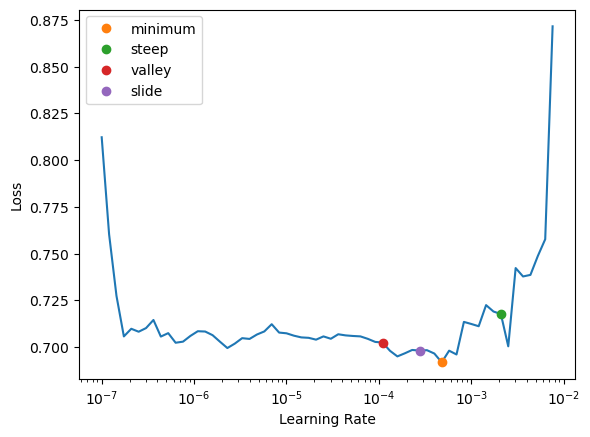

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.578456,0.347542,0.860000,00:22
1,0.250064,0.196667,0.920000,00:22
2,0.146691,0.187939,0.930000,00:23


In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.14669065177440643
valid_loss 0.18793916702270508
accuracy 0.9300000071525574


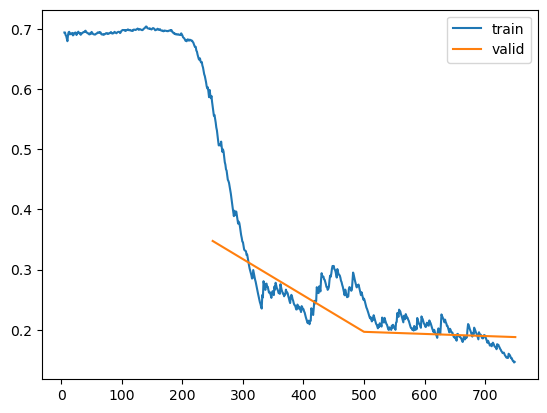

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.export("../models/test_topic_segmentation.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_new_hf_objects(civil_labels)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `torch.utils.data.Dataset`s

In [ ]:
print("Train|Validation examples: ", len(civil_train_ds), len(civil_valid_ds))

print(civil_train_ds[:2])
print("")
print(civil_train_ds["text"][:2])

Train|Validation examples:  1000 200
{'text': ['At least the Guptas looked after the employment of citizens. Gordhan,  Rupert and other White Monopoly Capitalists do not seem to give a damn about the citizens.', "I don't see a problem at all.\n\nShe is on the way out, which is totally sad as she is the BEST Prime Minister this country will never have!\n\nWho would you rather have on the bow of your boat?"], 'toxicity': [0, 0], 'severe_toxicity': [0, 0], 'obscene': [0, 0], 'threat': [0, 0], 'insult': [0, 0], 'identity_attack': [0, 0], 'sexual_explicit': [0, 0], 'is_valid': [False, False]}

['At least the Guptas looked after the employment of citizens. Gordhan,  Rupert and other White Monopoly Capitalists do not seem to give a damn about the citizens.', "I don't see a problem at all.\n\nShe is on the way out, which is totally sad as she is the BEST Prime Minister this country will never have!\n\nWho would you rather have on the bow of your boat?"]


In [ ]:
# tokenize the dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_civil_train_ds = civil_train_ds.map(tokenize_func, batched=True)
proc_civil_train_ds.set_format("torch", columns=hf_tokenizer.model_input_names + civil_labels)

proc_civil_valid_ds = civil_valid_ds.map(tokenize_func, batched=True)
proc_civil_valid_ds.set_format("torch", columns=hf_tokenizer.model_input_names + civil_labels)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
# define our PyTorch Dataset class
class HFTextMultilabelClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, hf_tokenizer, labels):
        self.hf_dataset = hf_dataset
        self.hf_tokenizer = hf_tokenizer
        self.labels = labels

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        item["label"] = [item[lbl] for lbl in self.labels]
        return item


# build our PyTorch training and validation Datasets
pt_proc_civil_train_ds = HFTextMultilabelClassificationDataset(proc_civil_train_ds, hf_tokenizer=hf_tokenizer, labels=civil_labels)
pt_proc_civil_valid_ds = HFTextMultilabelClassificationDataset(proc_civil_valid_ds, hf_tokenizer=hf_tokenizer, labels=civil_labels)

##### Step 3: `DataLoaders`

In [ ]:
# build your fastai `DataLoaders` from Pytorch `DataLoader` objects
batch_size = 4
data_collator = TextCollatorWithPadding(hf_tokenizer)
train_dl = torch.utils.data.DataLoader(pt_proc_civil_train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
valid_dl = torch.utils.data.DataLoader(pt_proc_civil_valid_ds, batch_size=batch_size * 2, shuffle=False, collate_fn=data_collator)

dls = DataLoaders(train_dl, valid_dl)

In [ ]:
print(len(train_dl), len(valid_dl))

b = next(iter(train_dl))
print(len(b))
print("")
print(hf_tokenizer.decode(b[0]["input_ids"][0][:200]))
print("")
print(b[1])

# b

250 25
2

[CLS] And the crazy...or diabolical...keeps on coming. I smell Bannon behind this one too, like most things Trump does.[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]

tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0,

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# learn.dls.valid.show_batch()

In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'one_batch'
# learn.summary()

##### Step 5: Train

SuggestedLRs(minimum=0.0006309573538601399, steep=0.0003311311302240938, valley=0.00013182566908653826, slide=0.0002290867705596611)

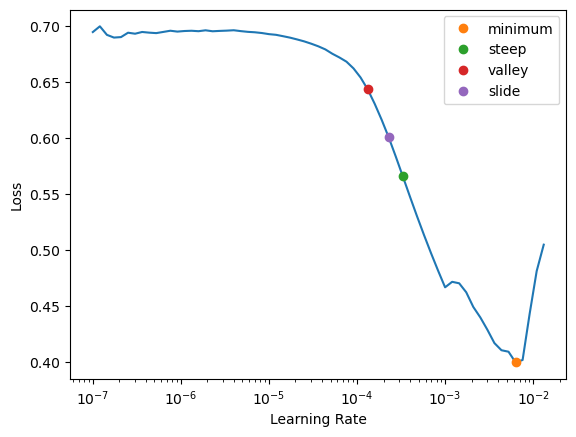

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.153990,0.061244,0.987143,00:14
1,0.077770,0.059023,0.987143,00:14
2,0.085857,0.058790,0.987143,00:15


In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.08585663884878159
valid_loss 0.058790042996406555
accuracy_multi 0.9871429204940796


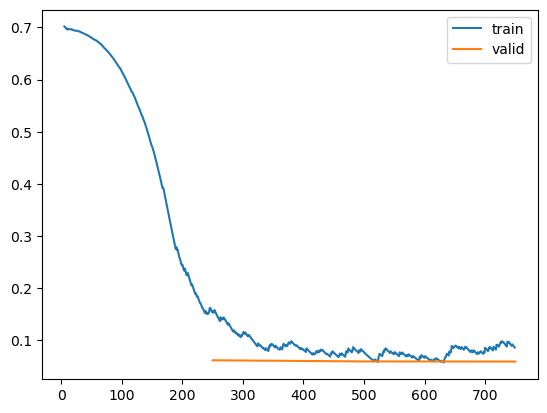

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.export("../models/test_topic_segmentation.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

### Hugging Face

#### Multiclass

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_new_hf_objects(labels)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Datasets`

We'll use the Hugging Face `Dataset` objects created in *Setup*, but these could just as well be instances of `torch.utils.data.Dataset`

In [ ]:
print("Train|Validation examples: ", len(train_ds), len(valid_ds))

print(train_ds[:2])
print("")
print(train_ds["text"][:2])

Train|Validation examples:  1000 200
{'text': ["This movie is just plain terrible!!!! Slow acting, slow at getting to the point and wooden characters that just shouldn't have been on there. The best part was the showing of Iron Maiden singing in some video at a theater and thats it. the ending was worth watching and waiting up for but that was it!! The characters in this movie put me to sleep almost. Avoid it!!!", "It would require the beauty and eloquence of Shakespeare to do justice to this outstanding cinematic feat. Nevertheless, I'll give it a go.<br /><br />As far as adaptations of Hamlet go this one is already at a better starting point than all other versions since it encompasses the entire play. Still this is no guarantee for a first-rate movie, or even a good one. Usually I'm not much for movies that are overlong and the trend that seems to be prevalent in Hollywood today, namely that movies should be at least two hours long, preferably three, is one that hopefully won't last

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_train_ds = train_ds.map(tokenize_func, batched=True)
proc_train_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

proc_valid_ds = valid_ds.map(tokenize_func, batched=True)
proc_valid_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

print(proc_train_ds)
print(proc_valid_ds)

Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-02466e60ae96d80b.arrow


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'is_valid', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})
Dataset({
    features: ['text', 'label', 'is_valid', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 200
})


##### Step 3: `DataLoaders`

In [ ]:
# build your fastai `DataLoaders` from Pytorch `DataLoader` objects
batch_size = 4
data_collator = TextCollatorWithPadding(hf_tokenizer)
train_dl = torch.utils.data.DataLoader(proc_train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
valid_dl = torch.utils.data.DataLoader(proc_valid_ds, batch_size=batch_size * 2, shuffle=False, collate_fn=data_collator)

dls = DataLoaders(train_dl, valid_dl)

In [ ]:
print(len(train_dl), len(valid_dl))

b = next(iter(train_dl))
print(len(b))
print("")
print(hf_tokenizer.decode(b[0]["input_ids"][0][:200]))
print("")
print(b[1])

# b

250 25
2

[CLS] I've read all the comments on this film. I am a great admirer<br /><br />of the Dalai Lama. As such, I read the book upon which this<br /><br />film was based. The movie is an ugly and demeaning fictionalization of the truth. I do not criticize it for<br /><br />altering small details or events for dramatic purposes; it is<br /><br />not a documentary. But the script CHANGES the impact, reaction,<br /><br />realities, and changes in EVERY main character. It vastly alters<br /><br />the real relationship between Harrar and the young Dalai Lama. <br /><br />From the ridiculous rivalry for a Tibetan woman (which demeans<br /><br />the culture of Tibet) to Harra's music box gift, to Harrar's<

tensor([0, 0, 0, 0])


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=PreCalculatedCrossEntropyLoss(),  # CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# learn.dls.valid.show_batch()

In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'one_batch'
# learn.summary()

##### Step 5: Train

SuggestedLRs(minimum=2.2908675418875645e-07, steep=0.0020892962347716093, valley=6.30957365501672e-05, slide=0.0004786300996784121)

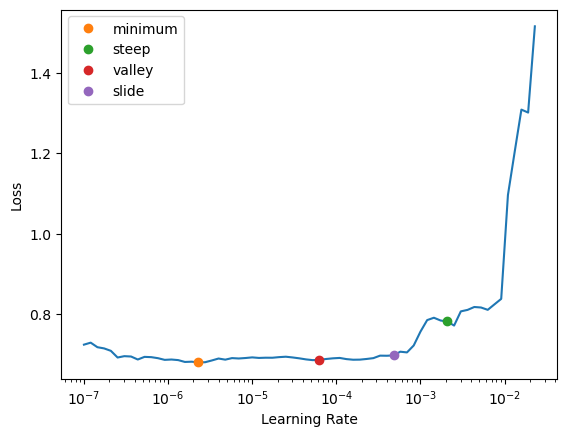

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.646754,0.493134,0.865000,00:22
1,0.244525,0.179014,0.920000,00:24
2,0.131130,0.170927,0.920000,00:23


In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.13112987577915192
valid_loss 0.1709267795085907
accuracy 0.9200000166893005


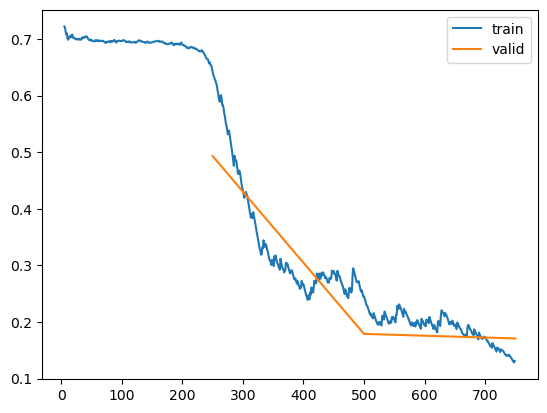

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.export("../models/test_topic_segmentation.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_new_hf_objects(civil_labels)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Datasets`

We'll use the Hugging Face `Dataset` objects created in *Setup*, but these could just as well be instances of `torch.utils.data.Dataset`

In [ ]:
print("Train|Validation examples: ", len(civil_train_ds), len(civil_valid_ds))

print(civil_train_ds[:2])
print("")
print(civil_train_ds["text"][:2])

Train|Validation examples:  1000 200
{'text': ['At least the Guptas looked after the employment of citizens. Gordhan,  Rupert and other White Monopoly Capitalists do not seem to give a damn about the citizens.', "I don't see a problem at all.\n\nShe is on the way out, which is totally sad as she is the BEST Prime Minister this country will never have!\n\nWho would you rather have on the bow of your boat?"], 'toxicity': [0, 0], 'severe_toxicity': [0, 0], 'obscene': [0, 0], 'threat': [0, 0], 'insult': [0, 0], 'identity_attack': [0, 0], 'sexual_explicit': [0, 0], 'is_valid': [False, False]}

['At least the Guptas looked after the employment of citizens. Gordhan,  Rupert and other White Monopoly Capitalists do not seem to give a damn about the citizens.', "I don't see a problem at all.\n\nShe is on the way out, which is totally sad as she is the BEST Prime Minister this country will never have!\n\nWho would you rather have on the bow of your boat?"]


In [ ]:
# tokenize the dataset
def tokenize_func(example):
    updated_example = dict(hf_tokenizer(example["text"], truncation=True))
    labels = torch.stack([tensor(example[lbl]) for lbl in civil_labels], dim=-1)
    updated_example["label"] = labels

    return updated_example


proc_civil_train_ds = civil_train_ds.map(tokenize_func, batched=True)
# proc_civil_train_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

proc_civil_valid_ds = civil_valid_ds.map(tokenize_func, batched=True, batch_size=4)
# proc_civil_valid_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

print(proc_civil_train_ds)
print(proc_civil_valid_ds)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit', 'is_valid', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 1000
})
Dataset({
    features: ['text', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit', 'is_valid', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 200
})


##### Step 3: `DataLoaders`

In [ ]:
# build your fastai `DataLoaders` from Pytorch `DataLoader` objects
batch_size = 4
data_collator = TextCollatorWithPadding(hf_tokenizer)
train_dl = torch.utils.data.DataLoader(proc_civil_train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
valid_dl = torch.utils.data.DataLoader(proc_civil_valid_ds, batch_size=batch_size * 2, shuffle=False, collate_fn=data_collator)

dls = DataLoaders(train_dl, valid_dl)

In [ ]:
print(len(train_dl), len(valid_dl))

b = next(iter(train_dl))
print(len(b))
print("")
print(hf_tokenizer.decode(b[0]["input_ids"][0][:200]))
print("")
print(b[1])

# b

250 25
2

[CLS] And the crazy...or diabolical...keeps on coming. I smell Bannon behind this one too, like most things Trump does.[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]

tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0,

In [ ]:
b[1].dtype

torch.int64

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# learn.dls.valid.show_batch()

In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'one_batch'
# learn.summary()

##### Step 5: Train

SuggestedLRs(minimum=0.0006309573538601399, steep=0.019054606556892395, valley=0.00013182566908653826, slide=0.0002290867705596611)

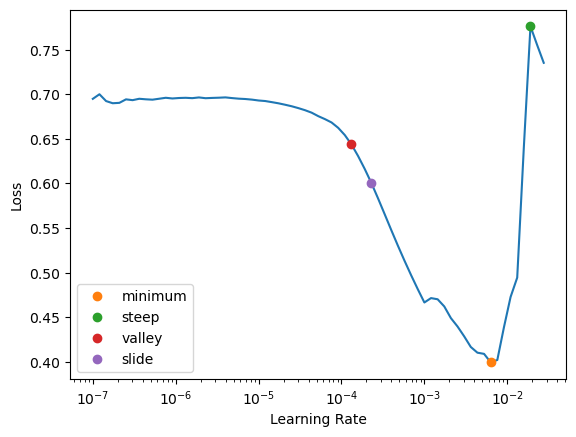

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.157481,0.061634,0.987143,00:16
1,0.077230,0.058608,0.987143,00:15
2,0.083457,0.058210,0.987143,00:15


In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.08345676958560944
valid_loss 0.05820956081151962
accuracy_multi 0.9871429204940796


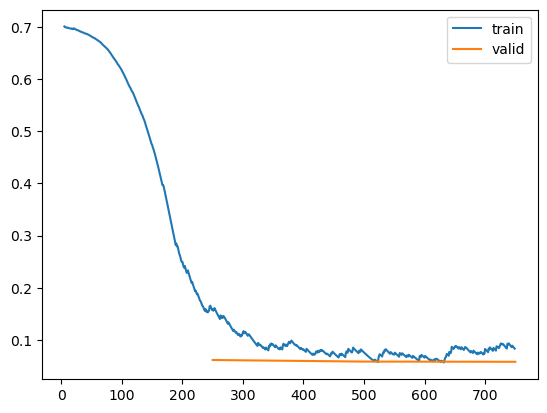

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.export("../models/test_topic_segmentation.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

## Low-Level API: Data

This section demonstrates how you can migrate from using PyTorch/Hugging Face to fast.ai `Datasets` and `DataLoaders` to recapture much of the fast.ai specific features unavailable when using basic PyTorch.

### `TextInput` -

In [ ]:
# |export
class TextInput(TensorBase):
    """The base represenation of your inputs; used by the various fastai `show` methods"""

    pass

A `TextInput` object is returned from the decodes method of `BatchDecodeTransform` as a means to customize `@typedispatch`ed functions like `DataLoaders.show_batch` and `Learner.show_results`. The value will the your "input_ids".

### `BatchDecodeTransform` -

In [ ]:
# |export
class BatchDecodeTransform(Transform):
    """A class used to cast your inputs as `input_return_type` for fastai `show` methods"""

    def __init__(
        self,
        # A Hugging Face tokenizer (not required if passing in an instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_tokenizer: PreTrainedTokenizerBase,
        # The abbreviation/name of your Hugging Face transformer architecture (not required if passing in an instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_arch: str = None,
        # A Hugging Face configuration object (not required if passing in an instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_config: PretrainedConfig = None,
        # A Hugging Face model (not required if passing in an instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_model: PreTrainedModel = None,
        # Used by typedispatched show methods
        input_return_type: type = TextInput,
        # Any other keyword arguments
        **kwargs,
    ):
        store_attr()
        self.kwargs = kwargs

    def decodes(self, items):
        """Returns the proper object and data for show related fastai methods"""
        inps = self.input_return_type(items[0]["input_ids"])
        if len(items) > 1:
            return inps, *items[1:]
        else:
            labels = items[0].get("labels", [None] * items[0]["input_ids"])
            return inps, labels

As of fastai 2.1.5, before batch transforms no longer have a `decodes` method ... and so, I've introduced a standard batch transform here, `BatchDecodeTransform`, (one that occurs "after" the batch has been created) that will do the decoding for us.

### Utility classes and methods 

These methods are use internally for getting blurr transforms associated to your `DataLoaders`

In [ ]:
# |export
def get_blurr_tfm(
    # A list of transforms (e.g., dls.after_batch, dls.before_batch, etc...)
    tfms_list: Pipeline,
    # The transform to find
    tfm_class: Transform = BatchDecodeTransform,
):
    """
    Given a fastai DataLoaders batch transforms, this method can be used to get at a transform
    instance used in your Blurr DataBlock
    """
    return next(filter(lambda el: issubclass(type(el), tfm_class), tfms_list), None)

In [ ]:
nbdev.show_doc(get_blurr_tfm, title_level=3)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/text/core.py#L236){target="_blank" style="float:right; font-size:smaller"}

### get_blurr_tfm

>      get_blurr_tfm (tfms_list:fastcore.transform.Pipeline,
>                     tfm_class:fastcore.transform.Transform=<class
>                     '__main__.BatchDecodeTransform'>)

Given a fastai DataLoaders batch transforms, this method can be used to get at a transform
instance used in your Blurr DataBlock

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| tfms_list | Pipeline |  | A list of transforms (e.g., dls.after_batch, dls.before_batch, etc...) |
| tfm_class | Transform | BatchDecodeTransform | The transform to find |

In [ ]:
# |export
def first_blurr_tfm(
    # Your fast.ai `DataLoaders
    dls: DataLoaders,
    # The Blurr transforms to look for in order
    tfms: list[Transform] = [BatchDecodeTransform],
):
    """
    This convenience method will find the first Blurr transform required for methods such as
    `show_batch` and `show_results`. The returned transform should have everything you need to properly
    decode and 'show' your Hugging Face inputs/targets
    """
    for tfm in tfms:
        found_tfm = get_blurr_tfm(dls.before_batch, tfm_class=tfm)
        if found_tfm:
            return found_tfm

        found_tfm = get_blurr_tfm(dls.after_batch, tfm_class=tfm)
        if found_tfm:
            return found_tfm

In [ ]:
nbdev.show_doc(first_blurr_tfm, title_level=3)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/text/core.py#L249){target="_blank" style="float:right; font-size:smaller"}

### first_blurr_tfm

>      first_blurr_tfm (dls:fastai.data.core.DataLoaders,
>                       tfms:list[fastcore.transform.Transform]=[<class
>                       '__main__.BatchDecodeTransform'>])

This convenience method will find the first Blurr transform required for methods such as
`show_batch` and `show_results`. The returned transform should have everything you need to properly
decode and 'show' your Hugging Face inputs/targets

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| dls | DataLoaders |  | Your fast.ai `DataLoaders |
| tfms | list[Transform] | [<class '__main__.BatchDecodeTransform'>] | The Blurr transforms to look for in order |

### `show_batch` -

In [ ]:
# |export
@typedispatch
def show_batch(
    # This typedispatched `show_batch` will be called for `TextInput` typed inputs
    x: TextInput,
    # Your targets
    y,
    # Your raw inputs/targets
    samples,
    # Your `DataLoaders`. This is required so as to get at the Hugging Face objects for
    # decoding them into something understandable
    dataloaders,
    # Your `show_batch` context
    ctxs=None,
    # The maximum number of items to show
    max_n=6,
    # Any truncation your want applied to your decoded inputs
    trunc_at=None,
    # Any other keyword arguments you want applied to `show_batch`
    **kwargs,
):
    # grab our tokenizer
    tfm = first_blurr_tfm(dataloaders)
    hf_tokenizer = tfm.hf_tokenizer

    # if we've included our labels list, we'll use it to look up the value of our target(s)
    trg_labels = tfm.kwargs["labels"] if ("labels" in tfm.kwargs) else None

    res = L()
    n_inp = dataloaders.n_inp

    n_samples = min(max_n, dataloaders.bs)
    for idx in range(n_samples):
        input_ids = x[idx]
        label = y[idx] if y is not None else None
        sample = samples[idx] if samples is not None else None

        rets = [hf_tokenizer.decode(input_ids, skip_special_tokens=True)[:trunc_at]]
        for item in sample[n_inp:]:
            if not torch.is_tensor(item):
                trg = trg_labels[int(item)] if trg_labels else item
            elif is_listy(item.tolist()):
                trg = [trg_labels[idx] for idx, val in enumerate(label.numpy().tolist()) if (val == 1)] if (trg_labels) else label.numpy()
            else:
                trg = trg_labels[label.item()] if (trg_labels) else label.item()

            rets.append(trg)
        res.append(tuplify(rets))

    cols = ["text"] + ["target" if (i == 0) else f"target_{i}" for i in range(len(res[0]) - n_inp)]
    display_df(pd.DataFrame(res, columns=cols)[:max_n])
    return ctxs

### `TextDataLoader` -

In [ ]:
# |export
@delegates()
class TextDataLoader(TfmdDL):
    """
    A transformed `DataLoader` that works with Blurr.
    From the fastai docs: A `TfmDL` is described as "a DataLoader that creates Pipeline from a list of Transforms
    for the callbacks `after_item`, `before_batch` and `after_batch`. As a result, it can decode or show a processed batch.
    """

    def __init__(
        self,
        # A standard PyTorch Dataset
        dataset: torch.utils.data.dataset.Dataset | Datasets,
        # A Hugging Face tokenizer (not required if passing in an instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_tokenizer: PreTrainedTokenizerBase,
        # The abbreviation/name of your Hugging Face transformer architecture (not required if passing in an \
        # instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_arch: str = None,
        # A Hugging Face configuration object (not required if passing in an  \
        # instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_config: PretrainedConfig = None,
        # A Hugging Face model (not required if passing in an instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_model: PreTrainedModel = None,
        # An instance of `TextCollatorWithPadding` or equivalent (defaults to `BlurrBatchCreator`)
        text_collator: TextCollatorWithPadding = None,
        # The batch_tfm used to decode Blurr batches (defaults to `BatchDecodeTransform`)
        batch_decode_tfm: BatchDecodeTransform = None,
        # Used by typedispatched show methods
        input_return_type: type = TextInput,
        # Keyword arguments to be applied to your `batch_decode_tfm`
        batch_decode_kwargs: dict = {},
        # Keyword arguments to be applied to `BlurrDataLoader`
        **kwargs,
    ):
        # define what happens when a batch is created (e.g., this is where collation happens)
        if "create_batch" in kwargs:
            kwargs.pop("create_batch")
        if not text_collator:
            text_collator = TextCollatorWithPadding(hf_tokenizer, hf_arch, hf_config, hf_model)

        # define the transform applied after the batch is created (used of show methods)
        if "after_batch" in kwargs:
            kwargs.pop("after_batch")
        if not batch_decode_tfm:
            batch_decode_tfm = BatchDecodeTransform(
                hf_tokenizer,
                hf_arch,
                hf_config,
                hf_model,
                input_return_type,
                **batch_decode_kwargs.copy(),
            )

        super().__init__(
            dataset=dataset,
            create_batch=text_collator,
            after_batch=batch_decode_tfm,
            **kwargs,
        )
        store_attr()

    def new(
        self,
        # A standard PyTorch and fastai dataset
        dataset: Union[torch.utils.data.dataset.Dataset, Datasets] = None,
        # The class you want to create an instance of (will be "self" if None)
        cls: type = None,
        #  Any additional keyword arguments you want to pass to the __init__ method of `cls`
        **kwargs,
    ):
        """
        We have to override the new method in order to add back the Hugging Face objects in this factory
        method (called for example in places like `show_results`). With the exception of the additions to the kwargs
        dictionary, the code below is pulled from the `DataLoaders.new` method as is.
        """
        # we need to add these arguments back in (these, after_batch, and create_batch will go in as kwargs)
        kwargs["hf_arch"] = self.hf_arch
        kwargs["hf_config"] = self.hf_config
        kwargs["hf_tokenizer"] = self.hf_tokenizer
        kwargs["hf_model"] = self.hf_model

        kwargs["text_collator"] = self.text_collator
        kwargs["batch_decode_tfm"] = self.batch_decode_tfm
        kwargs["batch_decode_kwargs"] = self.batch_decode_kwargs

        return super().new(dataset, cls, **kwargs)

## Low-Level API: Examples

### Using fast.ai `Datasets` and `DataLoaders`

#### Multiclass

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_new_hf_objects(labels)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Datasets`

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_imdb_ds = imdb_ds.map(tokenize_func, batched=True)
proc_imdb_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

# turn Arrow into DataFrame (`ColSplitter` only works with `DataFrame`s)
train_df = pd.DataFrame(proc_imdb_ds)
train_df.head()

# define dataset splitter
splitter = ColSplitter("is_valid")
splits = splitter(imdb_df)


# define how we want to build our inputs and targets
def _build_inputs(example):
    return {fwd_arg_name: example[fwd_arg_name] for fwd_arg_name in hf_tokenizer.model_input_names if fwd_arg_name in list(example.keys())}


def _build_targets(example):
    return example["label"]


# create our fastai `Datasets` object
dsets = Datasets(items=train_df, splits=splits, tfms=[[_build_inputs], _build_targets], n_inp=1)

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

In [ ]:
print("Items in train|validation datasets: ", len(dsets.train), len(dsets.valid))

example = dsets.valid[0]
# example

print(f"Items in each example: {len(example)}")
print(f"Example inputs: {list(example[0].keys())}")
print(f"Example target(s): {example[1]}")

Items in train|validation datasets:  1000 200
Items in each example: 2
Example inputs: ['input_ids', 'token_type_ids', 'attention_mask']
Example target(s): 0


##### Step 3: `DataLoaders`

In [ ]:
def sorted_dl_func(item):
    return len(item[0]["input_ids"])


data_collator = TextCollatorWithPadding(hf_tokenizer)
dls = dsets.dataloaders(
    batch_size=4,
    create_batch=data_collator,
    dl_type=partial(SortedDL, sort_func=sorted_dl_func),
)

In [ ]:
print(len(dls.train), len(dls.valid))

b = dls.valid.one_batch()
print(len(b))
print("")
print(hf_tokenizer.decode(b[0]["input_ids"][0][:200]))
print("")
print(b[1])

250 50
2

[CLS] The first half of this film held some promise as it seemed like the film was going to be a low-key character psychodrama like THE MINUS MAN but then the whole thing collapses into cliche and the viewer slowly loses all interest. There's a decent cast here but the film is lifeless and the talent completely wasted.[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]

tensor([0, 0, 1, 0], device='cuda:0')


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Will work assuming we define a suitable `show_batch()`` method for our examples
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# learn.dls.valid.show_batch()

In [ ]:
# YES: Since we're using fastai `DataLoaders`, we get `one_batch()` back
learn.summary()

BaseModelWrapper (Input shape: 4 x 1355)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 1355 x 768      
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 1355 x 3072     
Linear                        

##### Step 5: Train

SuggestedLRs(minimum=5.248074739938602e-06, steep=0.013182567432522774, valley=9.999999747378752e-06, slide=0.0008317637839354575)

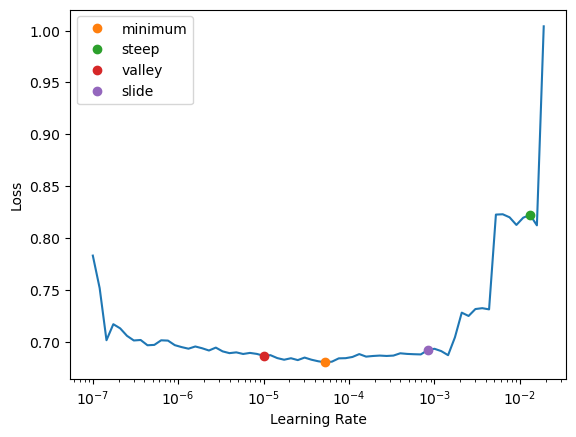

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.674510,0.602659,0.705000,00:20
1,0.265319,0.189017,0.925000,00:19
2,0.192577,0.180845,0.935000,00:23


In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.19257691502571106
valid_loss 0.18084508180618286
accuracy 0.9350000023841858


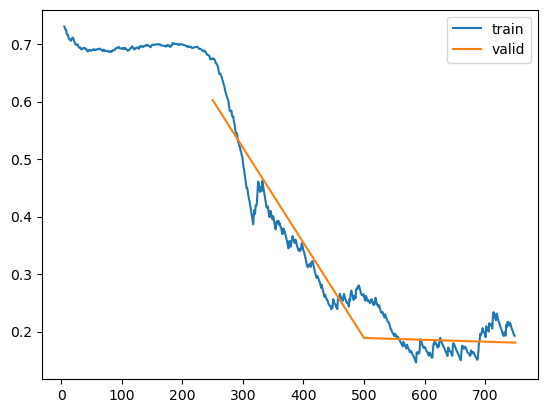

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results()

In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
# AttributeError: 'DataLoader' object has no attribute 'new'
learn.export("../models/test_text_core_low_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_new_hf_objects(civil_labels)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Datasets`

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    updated_example = dict(hf_tokenizer(example["text"], truncation=True))
    labels = torch.stack([tensor(example[lbl]) for lbl in civil_labels], dim=-1)
    updated_example["label"] = labels

    return updated_example


proc_civil_ds = civil_ds.map(tokenize_func, batched=True)
proc_civil_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

# turn Arrow into DataFrame (`ColSplitter` only works with `DataFrame`s)
train_df = pd.DataFrame(proc_civil_ds)
train_df.head()

# define dataset splitter
splitter = ColSplitter("is_valid")
splits = splitter(civil_df)


# define how we want to build our inputs and targets
def _build_inputs(example):
    return {fwd_arg_name: example[fwd_arg_name] for fwd_arg_name in hf_tokenizer.model_input_names if fwd_arg_name in list(example.keys())}


def _build_targets(example):
    return example["label"]


# create our fastai `Datasets` object
dsets = Datasets(items=train_df, splits=splits, tfms=[[_build_inputs], _build_targets], n_inp=1)

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

In [ ]:
print("Items in train|validation datasets: ", len(dsets.train), len(dsets.valid))

example = dsets.valid[0]
# example

print(f"Items in each example: {len(example)}")
print(f"Example inputs: {list(example[0].keys())}")
print(f"Example target(s): {example[1]}")

Items in train|validation datasets:  1000 200
Items in each example: 2
Example inputs: ['input_ids', 'token_type_ids', 'attention_mask']
Example target(s): tensor([0, 0, 0, 0, 0, 0, 0])


##### Step 3: `DataLoaders`

In [ ]:
def sorted_dl_func(item):
    return len(item[0]["input_ids"])


data_collator = TextCollatorWithPadding(hf_tokenizer)
dls = dsets.dataloaders(
    batch_size=4,
    create_batch=data_collator,
    dl_type=partial(SortedDL, sort_func=sorted_dl_func),
)

In [ ]:
print(len(dls.train), len(dls.valid))

b = dls.valid.one_batch()
print(len(b))
print("")
print(hf_tokenizer.decode(b[0]["input_ids"][0][:200]))
print("")
print(b[1])

250 50
2

[CLS] TO: Bill Rodawalt In reply to: There is actually a well known phenomena in test scores.... Bill, it's not the kids, it's the teachers. The teachers get used to the tests and begin to focus on the specific questions (to the exclusion of all else). Look what happened in Texas. Prior to Bush becoming President, he was in charge of the testing and test management. He completely rewrote the tests, but in a very unusual move, he gave the tests out to the teachers so they The teachers) naturally restructured their classroom teaching to match the questions and 'bingo,' the kids did great. The kids were not smarter (actually the SAT & ACT test scores showed they were dumber) but man did they do well on the State run tests (LOL). If you want'smarter' kids, one factor runs head and shoulders above all the rest. "You get the parents involved in their kid's educational process!

tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Will work assuming we define a suitable `show_batch()`` method for our examples
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# learn.dls.valid.show_batch()

In [ ]:
# YES: Since we're using fastai `DataLoaders`, we get `one_batch()` back
learn.summary()

BaseModelWrapper (Input shape: 4 x 242)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 242 x 768       
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 242 x 3072      
Linear                         

##### Step 5: Train

SuggestedLRs(minimum=0.0003019951749593019, steep=0.0002290867705596611, valley=0.0008317637839354575, slide=0.002511886414140463)

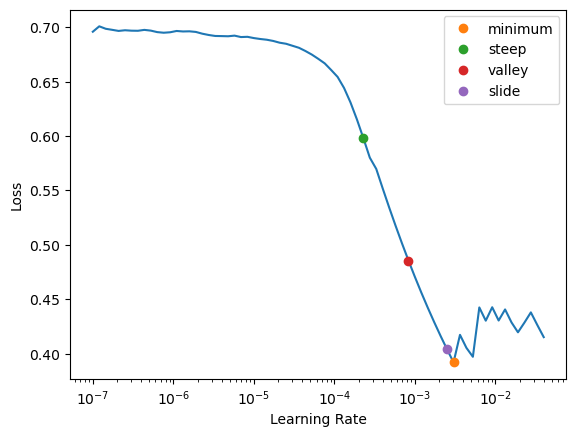

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.158491,0.059166,0.987143,00:16
1,0.079644,0.057062,0.987143,00:17
2,0.106417,0.057235,0.987143,00:15


In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.10641689598560333
valid_loss 0.057234641164541245
accuracy_multi 0.9871429204940796


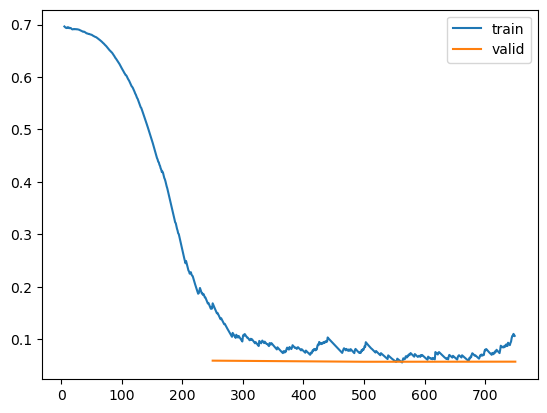

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results()

In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
# AttributeError: 'DataLoader' object has no attribute 'new'
learn.export("../models/test_text_core_low_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

### Using `BatchDecodeTransform` and `TextDataLoader`

#### Multiclass

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_new_hf_objects(labels)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Dataset`s

We'll use the Hugging Face `Dataset` objects created in *Setup*, but these could just as well be instances of `torch.utils.data.Dataset`

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_imdb_ds = imdb_ds.map(tokenize_func, batched=True)
# proc_imdb_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])


# define dataset splitter
def _split_func(example):
    return example["is_valid"] == True


splitter = FuncSplitter(_split_func)
splits = splitter(proc_imdb_ds)


# define how we want to build our inputs and targets
def _build_inputs(example):
    return {fwd_arg_name: example[fwd_arg_name] for fwd_arg_name in hf_tokenizer.model_input_names if fwd_arg_name in list(example.keys())}


def _build_targets(example):
    return example["label"]


# create our fastai `Datasets` object
dsets = Datasets(items=proc_imdb_ds, splits=splits, tfms=[[_build_inputs], _build_targets], n_inp=1)

Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-a043b33e6c8127ee.arrow


##### Step 3: `DataLoaders`

In [ ]:
label_names = train_ds.features["label"].names
label_names

['neg', 'pos']

In [ ]:
batch_size = 4

trn_dl = TextDataLoader(
    dsets.train,
    hf_tokenizer,
    batch_decode_kwargs={"labels": label_names},
    shuffle=True,
    batch_size=batch_size,
)

val_dl = TextDataLoader(
    dsets.valid,
    hf_tokenizer,
    batch_decode_kwargs={"labels": label_names},
    batch_size=batch_size * 2,
)

dls = DataLoaders(trn_dl, val_dl)

In [ ]:
print(len(dls.train), len(dls.valid))

b = dls.valid.one_batch()
print(len(b))
print("")
print(hf_tokenizer.decode(b[0]["input_ids"][0][:200]))
print("")
print(b[1])

250 25
2

[CLS] The first half of this film held some promise as it seemed like the film was going to be a low-key character psychodrama like THE MINUS MAN but then the whole thing collapses into cliche and the viewer slowly loses all interest. There's a decent cast here but the film is lifeless and the talent completely wasted.[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=800)

,text,target
0,"I do miss the company Vestron, they sure had their finger on the pulse of unique and unusual cinema back in the 1980s. This is very apparent with the astonishing Paperhouse, a film that touches me deeply each and every time I watch it.<br /><br />The idea of a girl manipulating a dream world with her drawings (thusly the dream world manipulating reality), and also connecting with and affecting the life of a boy she's never actually met, is fascinating and never disappoints. Charlotte Burke at first seems quite precocious and yet you warm up to her because by being a bit of a mischievous child, it makes it hard for the adults to believe what she is experiencing. She becomes very self aware and strong towards the end, even finding she doesn't ""hate boys"" as she so defiantly claimed at first.",pos
1,"Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines.<br /><br />At first it was very odd and pretty funny but as the movie progressed I didn't find the jokes or oddness funny anymore.<br /><br />Its a low budget film (thats never a problem in itself), there were some pretty interesting characters, but eventually I just lost interest.<br /><br />I imagine this film would appeal to a stoner who is currently partaking.<br /><br />For something similar but better try ""Brother from another planet""",neg


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# YES: Since we're using fastai `TfmDL` and including a transform that knows how to show our inputs,
# we get `show_batch()` back
learn.dls.valid.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,The first half of this film held some promise as it seemed like the film was going to be a low-key character psychodrama like THE MINUS MAN but then the whole thing collapses into cliche and the viewer slowly loses all interest. There's a decent cast,neg
1,"The over-riding problem with this film is that it can't possibly use Bill Murray to the best of his abilities, simply because of the co-star.<br /><br />If this was a road movie with another comedic actor, it might work. Even if they were both trying",neg


In [ ]:
# YES: Since we're using fastai `DataLoaders`, we get `learn.summary()` back
learn.summary()

BaseModelWrapper (Input shape: 4 x 404)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 404 x 768       
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 404 x 3072      
Linear                         

##### Step 5: Train

SuggestedLRs(minimum=2.290867705596611e-05, steep=0.019054606556892395, valley=9.120108734350652e-05, slide=0.0005754399462603033)

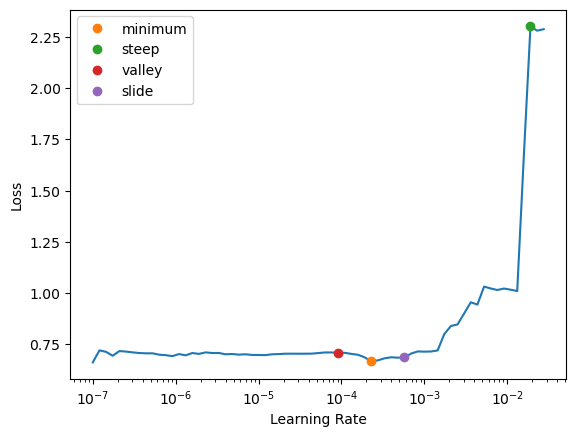

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.629641,0.378081,0.900000,00:24
1,0.227266,0.191481,0.920000,00:24
2,0.167924,0.169364,0.945000,00:24


In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.16792376339435577
valid_loss 0.1693638563156128
accuracy 0.9449999928474426


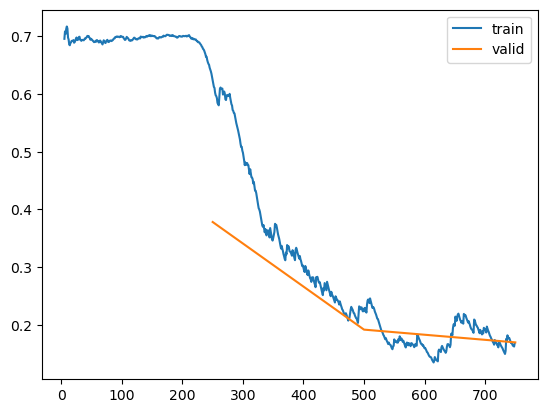

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results()

In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
learn.export("../models/test_text_core_low_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_new_hf_objects(civil_labels)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Dataset`s

We'll use the Hugging Face `Dataset` objects created in *Setup*, but these could just as well be instances of `torch.utils.data.Dataset`

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    updated_example = dict(hf_tokenizer(example["text"], truncation=True))
    labels = torch.stack([tensor(example[lbl]) for lbl in civil_labels], dim=-1)
    updated_example["label"] = labels

    return updated_example


proc_civil_ds = civil_ds.map(tokenize_func, batched=True)
# proc_imdb_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])


# define dataset splitter
def _split_func(example):
    return example["is_valid"] == True


splitter = FuncSplitter(_split_func)
splits = splitter(proc_civil_ds)


# define how we want to build our inputs and targets
def _build_inputs(example):
    return {fwd_arg_name: example[fwd_arg_name] for fwd_arg_name in hf_tokenizer.model_input_names if fwd_arg_name in list(example.keys())}


def _build_targets(example):
    return example["label"]


# create our fastai `Datasets` object
dsets = Datasets(items=proc_civil_ds, splits=splits, tfms=[[_build_inputs], _build_targets], n_inp=1)

Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/civil_comments/default/0.9.0/e7a3aacd2ab7d135fa958e7209d10b1fa03807d44c486e3c34897aa08ea8ffab/cache-64b9fe693600ecb0.arrow


##### Step 3: `DataLoaders`

In [ ]:
batch_size = 4

trn_dl = TextDataLoader(
    dsets.train,
    hf_tokenizer,
    batch_decode_kwargs={"labels": civil_labels},
    shuffle=True,
    batch_size=batch_size,
)

val_dl = TextDataLoader(
    dsets.valid,
    hf_tokenizer,
    batch_decode_kwargs={"labels": civil_labels},
    batch_size=batch_size * 2,
)

dls = DataLoaders(trn_dl, val_dl)

In [ ]:
print(len(dls.train), len(dls.valid))

b = dls.valid.one_batch()
print(len(b))
print("")
print(hf_tokenizer.decode(b[0]["input_ids"][0][:200]))
print("")
print(b[1])

250 25
2

[CLS] TO: Bill Rodawalt In reply to: There is actually a well known phenomena in test scores.... Bill, it's not the kids, it's the teachers. The teachers get used to the tests and begin to focus on the specific questions (to the exclusion of all else). Look what happened in Texas. Prior to Bush becoming President, he was in charge of the testing and test management. He completely rewrote the tests, but in a very unusual move, he gave the tests out to the teachers so they The teachers) naturally restructured their classroom teaching to match the questions and 'bingo,' the kids did great. The kids were not smarter (actually the SAT & ACT test scores showed they were dumber) but man did they do well on the State run tests (LOL). If you want'smarter' kids, one factor runs head and shoulders above all the rest. "You get the parents involved in their kid's educational process!

tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 

In [ ]:
dls.show_batch(dataloaders=dls, max_n=8)

,text,target
0,Monsieur O'Leary just found out that Quebec is actually part of Canada and not just a little south of Georgia. Perhaps now he can pédaler dans la semoule en l'ouest where he belongs.,[]
1,What an ignorant comment. Nobody has ignored North Korea. Were you hoping Obama was going to go there with guns ablazin'?,"[toxicity, insult]"
2,"Just this week the Caisse announced annual returns 3% less than OMERS. Returns have lagged the other big funds like Teachers and AIMCo over long periods too. The CPP post results on a March 31 calendar that makes comparison harder. Sabia has not been an investment success, perhaps a political one and at the Caisse that might be enough. He is well known to be a slow and plodding decision maker who misses opportunities due to inaction. The CDP lost money in the crisis as each silo, encouraged to maximize returns at the silo level, ended up in subprime. - no group more famously than the treasury group who we neck deep in ABCP. Sabia's response was to eliminate complexity. To some this may seem rational, but to do so implies a return to index funds and low overhead. Clearly, this did not happen. What would have been better would beto build enterprise wide risk management and investment allocation processes. Now his mantra is about owning good businesses, a meaningless slogan.",[]
3,Where do I find the website Jeff?,[]


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# YES: Since we're using fastai `TfmDL` and including a transform that knows how to show our inputs,
# we get `show_batch()` back
learn.dls.valid.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,"TO: Bill Rodawalt In reply to: There is actually a well known phenomena in test scores.... Bill, it's not the kids, it's the teachers. The teachers get used to the tests and begin to focus on the specific questions (to the exclusion of all else). Loo",[]
1,This might come as a shock to some of you but it turns out that Donald Trump is an @sshole.,[]


In [ ]:
# YES: Since we're using fastai `DataLoaders`, we get `learn.summary()` back
learn.summary()

BaseModelWrapper (Input shape: 4 x 175)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 175 x 768       
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 175 x 3072      
Linear                         

##### Step 5: Train

SuggestedLRs(minimum=0.00043651582673192023, steep=0.019054606556892395, valley=5.248074739938602e-05, slide=0.0006918309954926372)

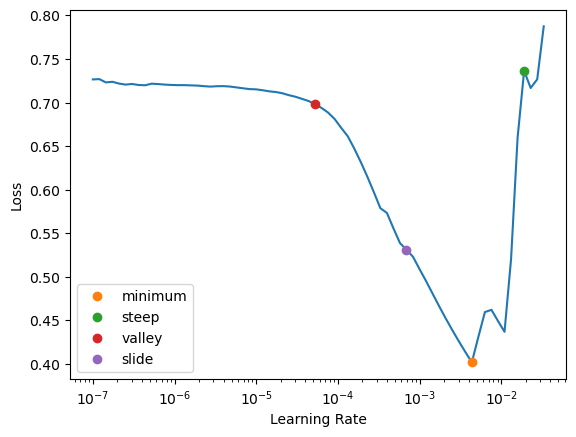

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.149082,0.060225,0.987143,00:15
1,0.074831,0.058786,0.987143,00:17
2,0.072600,0.058698,0.987143,00:16


In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.07260048389434814
valid_loss 0.05869820713996887
accuracy_multi 0.9871429204940796


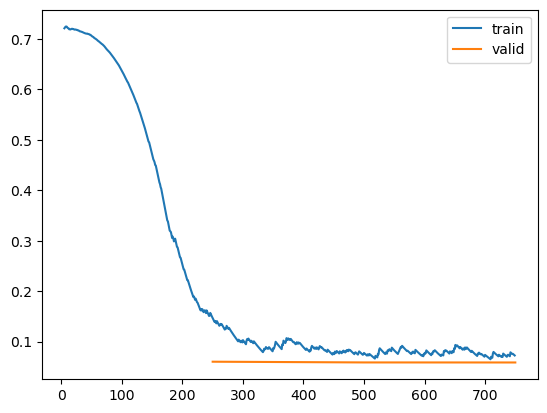

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results()

In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
learn.export("../models/test_text_core_low_level_multilabel.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

## Low-Level API: Predictions & Text Generation

**Prediction**

We need to replace fastai's `Learner.predict` method with the one above which is able to work with inputs that are represented by multiple tensors included in a dictionary.

**Text Generation**

With regards to **text generation**, though not useful in sequence classification, we will also add a `blurr_generate` method to `Learner` that uses Hugging Face's `PreTrainedModel.generate` for text generation tasks.  

For the full list of arguments you can pass in see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate). You can also check out their ["How To Generate"](https://github.com/huggingface/blog/blob/master/notebooks/02_how_to_generate.ipynb) notebook for more information about how it all works.

In [ ]:
# |export
@patch
def blurr_predict(self: Learner, items, rm_type_tfms=None, tok_is_split_into_words=False):
    # grab our blurr tfm with the bits to properly decode/show our inputs/targets
    tfm = first_blurr_tfm(self.dls)
    hf_tokenizer = tfm.hf_tokenizer
    trg_labels = tfm.kwargs["labels"] if ("labels" in tfm.kwargs) else None

    is_split_into_words = getattr(tfm, "is_split_into_words", tok_is_split_into_words)
    is_split_str = is_split_into_words == True and isinstance(items[0], str)
    is_df = isinstance(items, pd.DataFrame)

    if not is_df and (is_split_str or not is_listy(items)):
        items = [items]

    inputs_d = dict(
        hf_tokenizer(items, is_split_into_words=is_split_into_words, padding=True, max_length=True, truncation=True, return_tensors="pt")
    )
    encoded_items = [{k: inputs_d[k][idx] for k in inputs_d.keys()} for idx in range(len(inputs_d["input_ids"]))]
    dl = self.dls.test_dl(encoded_items, rm_type_tfms=rm_type_tfms, num_workers=0)

    with self.no_bar():
        probs, _, decoded_preds = self.get_preds(dl=dl, with_input=False, with_decoded=True)

    trg_tfms = self.dls.tfms[self.dls.n_inp :]

    outs = []
    is_multilabel = isinstance(self.loss_func, BCEWithLogitsLossFlat)
    probs, decoded_preds = L(probs), L(decoded_preds)
    for i in range(len(items)):
        item_probs = probs.itemgot(i)
        item_dec_preds = decoded_preds.itemgot(i)
        item_dec_labels = tuplify([tfm.decode(item_dec_preds[tfm_idx]) for tfm_idx, tfm in enumerate(trg_tfms)])[0]

        if trg_labels:
            # handle multiclass output
            if len(item_dec_labels.size()) == 0:
                item_dec_labels = [item_dec_labels.item()]
            # handle multilabel output
            else:
                item_dec_labels = [trg_labels[lbl_idx] for lbl_idx, lbl in enumerate(item_dec_labels) if lbl == True]

        res = {}
        if is_multilabel:
            res["labels"] = list(item_dec_labels)
            msk = item_dec_preds[0]
            res["scores"] = item_probs[0][msk].tolist()
            res["class_indices"] = [int(val) for val in item_dec_preds[0]]
        else:
            res["label"] = item_dec_labels[0]
            res["score"] = item_probs[0].tolist()[item_dec_preds[0]]
            res["class_index"] = item_dec_preds[0].item()

        if trg_labels is not None or hasattr(self.dls, "vocab"):
            res["class_labels"] = trg_labels if trg_labels else self.dls.vocab
        else:
            res["class_labels"] = None

        res["probs"] = item_probs[0].tolist()

        outs.append(res)
    return outs

In [ ]:
nbdev.show_doc(Learner.blurr_predict)

---

### Learner.blurr_predict

>      Learner.blurr_predict (items, rm_type_tfms=None,
>                             tok_is_split_into_words=False)

In [ ]:
inf_learn = load_learner("../models/test_text_core_low_level.pkl")

In [ ]:
inf_learn.blurr_predict("This is perhaps the best movie I have ever seen!!!")

[{'label': 1,
  'score': 0.6725509166717529,
  'class_index': 1,
  'class_labels': ['neg', 'pos'],
  'probs': [0.3274490535259247, 0.6725509166717529]}]

In [ ]:
inf_learn.blurr_predict("Acting was so bad it was almost funny.")

[{'label': 0,
  'score': 0.6316774487495422,
  'class_index': 0,
  'class_labels': ['neg', 'pos'],
  'probs': [0.6316774487495422, 0.36832255125045776]}]

In [ ]:
inf_learn.blurr_predict(["I really liked the movie", "Worse movie I ever saw"])

[{'label': 1,
  'score': 0.7363069653511047,
  'class_index': 1,
  'class_labels': ['neg', 'pos'],
  'probs': [0.26369303464889526, 0.7363069653511047]},
 {'label': 0,
  'score': 0.5403235554695129,
  'class_index': 0,
  'class_labels': ['neg', 'pos'],
  'probs': [0.5403235554695129, 0.45967644453048706]}]

In [ ]:
inf_learn = load_learner("../models/test_text_core_low_level_multilabel.pkl")

In [ ]:
inf_learn.blurr_predict("I will tell everyone what you did if you tell you jerk!")

[{'labels': [],
  'scores': [],
  'class_indices': [0, 0, 0, 0, 0, 0, 0],
  'class_labels': ['toxicity',
   'severe_toxicity',
   'obscene',
   'threat',
   'insult',
   'identity_attack',
   'sexual_explicit'],
  'probs': [0.05183248221874237,
   0.0010094037279486656,
   0.003064099932089448,
   0.0027754942420870066,
   0.033843159675598145,
   0.005902086850255728,
   0.00204725400544703]}]

In [ ]:
# |export
@patch
def blurr_generate(self: Learner, items, key="generated_texts", **kwargs):
    """Uses the built-in `generate` method to generate the text
    (see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate)
    for a list of arguments you can pass in)
    """
    if not is_listy(items):
        items = [items]

    # grab our blurr tfm with the bits to properly decode/show our inputs/targets
    tfm = first_blurr_tfm(self.dls)

    # grab the Hugging Face tokenizer from the learner's dls.tfms
    hf_tokenizer = tfm.hf_tokenizer
    tok_kwargs = tfm.tok_kwargs

    # grab the text generation kwargs
    text_gen_kwargs = tfm.text_gen_kwargs if (len(kwargs) == 0) else kwargs

    results = []
    for idx, inp in enumerate(items):
        if isinstance(inp, str):
            input_ids = hf_tokenizer.encode(inp, padding=True, truncation=True, return_tensors="pt", **tok_kwargs)
        else:
            # note (10/30/2020): as of pytorch 1.7, this has to be a plain ol tensor (not a subclass of TensorBase)
            input_ids = inp.as_subclass(Tensor)

        input_ids = input_ids.to(self.model.hf_model.device)

        gen_texts = self.model.hf_model.generate(input_ids, **text_gen_kwargs)
        outputs = [hf_tokenizer.decode(txt, skip_special_tokens=True, clean_up_tokenization_spaces=False) for txt in gen_texts]

        if tfm.hf_arch == "pegasus":
            outputs = [o.replace("<n>", " ") for o in outputs]

        results.append({key: outputs[0] if len(outputs) == 1 else outputs})

    return results

In [ ]:
nbdev.show_doc(Learner.blurr_generate)

---

### Learner.blurr_generate

>      Learner.blurr_generate (items, key='generated_texts', **kwargs)

Uses the built-in `generate` method to generate the text
(see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate)
for a list of arguments you can pass in)

## Mid-level API

### Tests

The tests below to ensure the core DataBlock code above works for **all** pretrained sequence classification models available in Hugging Face.  These tests are excluded from the CI workflow because of how long they would take to run and the amount of data that would be required to download.

**Note**: Feel free to modify the code below to test whatever pretrained classification models you are working with ... and if any of your pretrained sequence classification models fail, please submit a github issue *(or a PR if you'd like to fix it yourself)*

## Export -

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()